# Face Recognition

See: https://github.com/paoloripamonti/face-recognition.git

In [1]:
!pip install -U git+https://github.com/paoloripamonti/face-recognition.git

  Cloning https://github.com/paoloripamonti/face-recognition.git to /tmp/pip-req-build-aqrmyvao
  Running command git clone -q https://github.com/paoloripamonti/face-recognition.git /tmp/pip-req-build-aqrmyvao
     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for face-recognition: filename=face_recognition-0.1-cp36-none-any.whl size=6119 sha256=e7c81a91163ee5486492d9d8a2aab5d1298a3d379e9240b218d2fea0d44cf912
  Stored in directory: /tmp/pip-ephem-wheel-cache-fvycqi72/wheels/e0/3e/36/4b783af5dfc54e10601098cb30608b7d9c1a1f6fcfb26aeba1
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257692 sha256=1dcd5f77fee5ce5bd6a1c44119ff5f226b9ee925d5ec80f0e58344be9df58dcd
  Stored in directory: /tmp/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
  Created wheel for imutils: filename=imutils-0.5.3-cp36-none-any.whl size=25852 sha256=d18f7415d38cadbeee5422c1960205fa022b156e9960b454c0e99747211b3b46
  Stored in directory: /tmp/.ca

In [2]:
from face_recognition import FaceRecognition

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
from tqdm import tqdm
import requests
from pprint import pprint

Using TensorFlow backend.


### Settings

In [3]:
ROOT_FOLDER ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
MODEL_PATH = "lfw_model.pkl"

### Read dataset

In [1]:
dataset = []
for path in glob.iglob(os.path.join(ROOT_FOLDER, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) > 10)
dataset.head(10)

NameError: name 'glob' is not defined

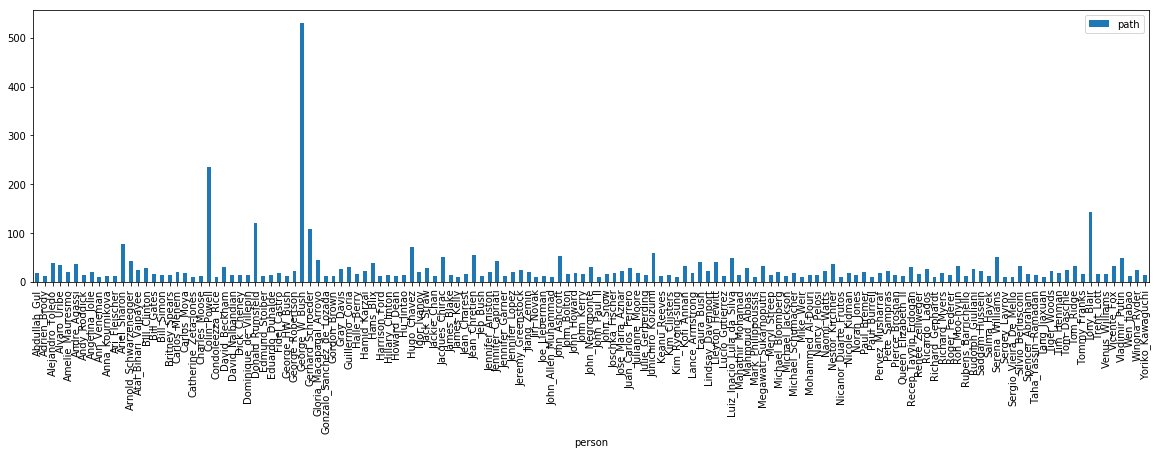

In [5]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

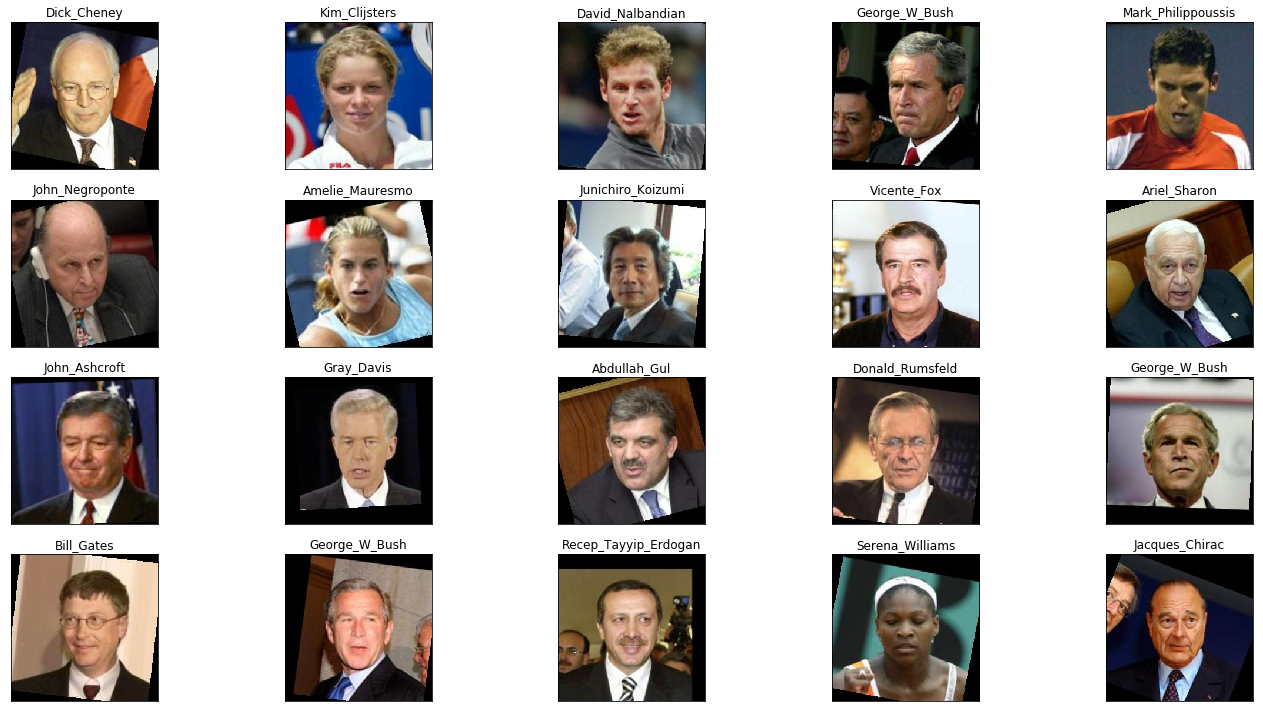

In [6]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Split train & test

In [7]:
train, test = train_test_split(dataset, test_size=0.1, random_state=0)
print("Train:",len(train))
print("Test:",len(test))

Train: 3756
Test: 418


### Fit Face Recognition

In [8]:
%%time
fr = FaceRecognition()

CPU times: user 19.9 s, sys: 908 ms, total: 20.8 s
Wall time: 23 s


In [9]:
%%time
fr.fit_from_dataframe(train)

100%|██████████| 3756/3756 [04:17<00:00, 13.43it/s]

CPU times: user 3min 52s, sys: 46.2 s, total: 4min 38s
Wall time: 4min 17s


In [10]:
fr.save(MODEL_PATH)

### Evaluate

In [11]:
%%time
y_test, y_pred, y_scores = [],[],[]
for idx in tqdm(range(len(test))):
    path = test.path.iloc[idx]
    result = fr.predict(path)
    for prediction in result["predictions"]:
        y_pred.append(prediction["person"])
        y_scores.append(prediction["confidence"])
        y_test.append(test.person.iloc[idx])

100%|██████████| 418/418 [00:32<00:00, 12.90it/s]

CPU times: user 30.2 s, sys: 4.95 s, total: 35.1 s
Wall time: 32.5 s


In [12]:
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

             Abdullah_Gul       0.80      0.80      0.80         5
             Adrien_Brody       1.00      0.75      0.86         4
         Alejandro_Toledo       0.75      1.00      0.86         3
             Alvaro_Uribe       1.00      0.80      0.89         5
          Amelie_Mauresmo       0.50      1.00      0.67         1
             Andre_Agassi       0.67      1.00      0.80         2
             Andy_Roddick       1.00      1.00      1.00         2
           Angelina_Jolie       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      1.00      1.00         2
            Ari_Fleischer       1.00      1.00      1.00         1
             Ariel_Sharon       0.89      1.00      0.94         8
    Arnold_Schwarzenegger       1.00      0.86      0.92         7
             Bill_Clinton       1.00      0.86      0.92         7
               Bill_Gates       0.75      1.00      0.86     

In [13]:
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.902335


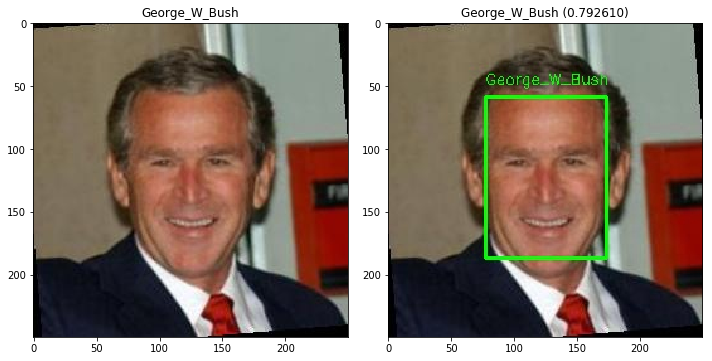

In [14]:
person = "George_W_Bush"
path = test[test.person==person]["path"].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = fr.predict(path)
file_bytes = np.fromstring(base64.b64decode(result["frame"]), np.uint8)
output = cv2.imdecode(file_bytes,1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(person)
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("%s (%f)" % (result["predictions"][0]["person"], result["predictions"][0]["confidence"]))
plt.tight_layout()
plt.show()

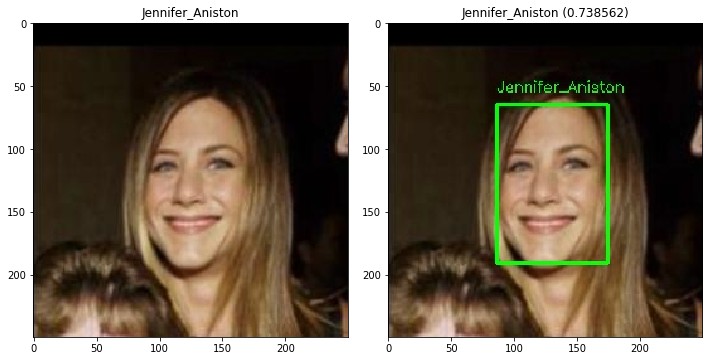

In [15]:
person = "Jennifer_Aniston"
path = test[test.person==person]["path"].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = fr.predict(path)
file_bytes = np.fromstring(base64.b64decode(result["frame"]), np.uint8)
output = cv2.imdecode(file_bytes,1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(person)
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("%s (%f)" % (result["predictions"][0]["person"], result["predictions"][0]["confidence"]))
plt.tight_layout()
plt.show()

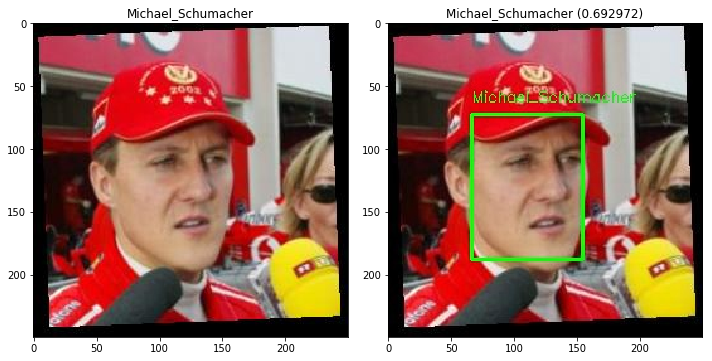

In [16]:
person = "Michael_Schumacher"
path = test[test.person==person]["path"].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = fr.predict(path)
file_bytes = np.fromstring(base64.b64decode(result["frame"]), np.uint8)
output = cv2.imdecode(file_bytes,1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(person)
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("%s (%f)" % (result["predictions"][0]["person"], result["predictions"][0]["confidence"]))
plt.tight_layout()
plt.show()

In [17]:
!wget -O img.jpg https://i.pinimg.com/originals/9e/1c/c9/9e1cc9329b82ad0084d5c4c30757d469.jpg

--2019-09-26 14:10:04--  https://i.pinimg.com/originals/9e/1c/c9/9e1cc9329b82ad0084d5c4c30757d469.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.9.32.132, 2600:1406:3c:397::1931, 2600:1406:3c:39b::1931
Connecting to i.pinimg.com (i.pinimg.com)|23.9.32.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59358 (58K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  57.97K   306KB/s    in 0.2s    

2019-09-26 14:10:05 (306 KB/s) - ‘img.jpg’ saved [59358/59358]



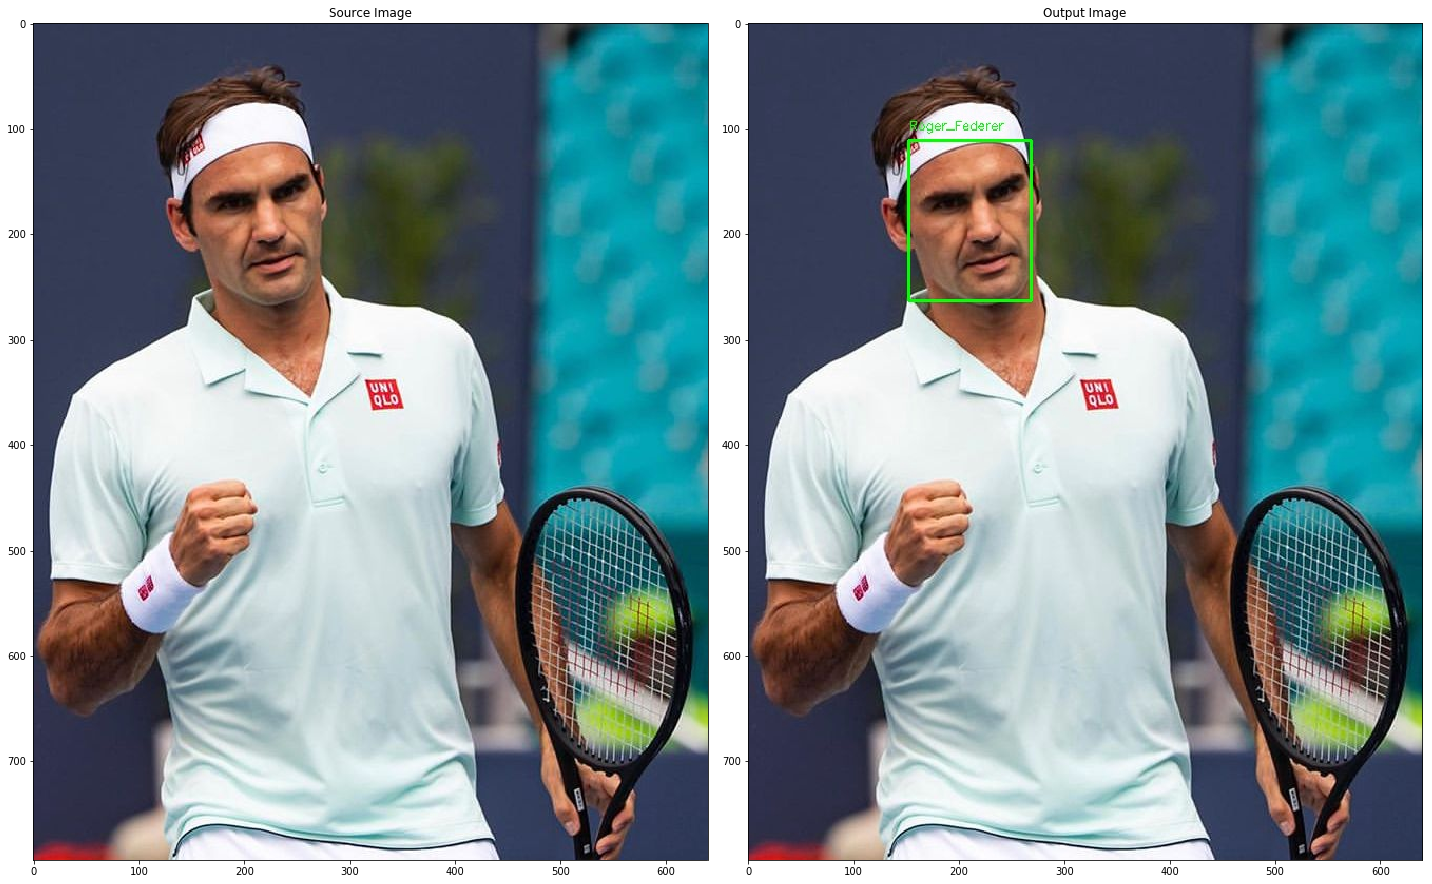

[{'box': (152, 111, 268, 263),
  'confidence': 0.6895488798618317,
  'person': 'Roger_Federer'}]


In [18]:
path = "img.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = fr.predict(path, threshold=0.3)
file_bytes = np.fromstring(base64.b64decode(result["frame"]), np.uint8)
output = cv2.imdecode(file_bytes,1)

plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Source Image")
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("Output Image")
plt.tight_layout()
plt.show()


pprint(result["predictions"])